# Introduction to Machine Learning - PROJECT

Authors: Aino Liukkonen and Raúl Cruz-Oliver

In [28]:
%reset -f

import pandas as pd
# Documentation
# https://pandas.pydata.org/docs

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# pip install statsmodels if you want to execute the blocks using statsmodels.api
import statsmodels.api as sm

## TEST EXAMPLE

In [30]:
# Our respective DATA folder paths
#data_folder = r'C:\Users\lenovo\Desktop\S7-DE\Introduction to Machine Learning\machine_learning_project\DATA'
data_folder = r'C:\Users\ainol\OneDrive\Tiedostot\TutaJaOhtu\Machine_Learning\course_project\DATA'

# Import Data
test = pd.read_excel(data_folder + r'\test.xlsx') #once we define the folder, the path is the same



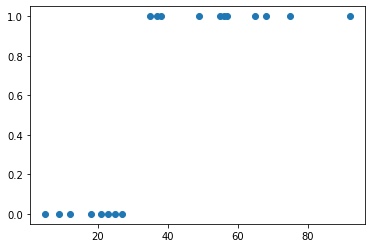

In [31]:
# Data visualization

# from data to vector
#x = test["Age"].to_numpy()
#y = test["Children"].to_numpy()


x = test["Age"].array
y = test["Children"].array



plt.scatter(x, y)

In [32]:
k = 1   #number of predictors, remember theta_0 is for the bias since x_o is always 1

sh=np.shape(x)
m=sh[0] #number of observations in the training data

#x=np.reshape(x, (m,1)) #predictors
x = x.reshape(-1, 1) 

#y=np.reshape(y, (m,1)) #labels
y = y.reshape(-1, 1) 

ones = np.ones ((m,1)) #for the bias x_0

X = np.concatenate((ones,x),axis=1) #matrix of training data

theta = np.random.rand(k+1,1)

#print(theta)
#print(X)

In [33]:
# logistic training

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_train(theta,X,y):   
    epsilon=1.0E-03
    alpha=0.1
    diff=epsilon+1
    theta_old=theta
    c=0
    while diff > epsilon:
        theta_old=theta
        error=sigmoid(np.dot(X,theta))-y
        theta = theta_old - (alpha/m)*np.dot(np.transpose(X),error)
        diff = np.linalg.norm(theta_old-theta)
        c=c+1
        if c == 10000:
            return theta
    return theta

theta=logistic_train(theta,X,y)    


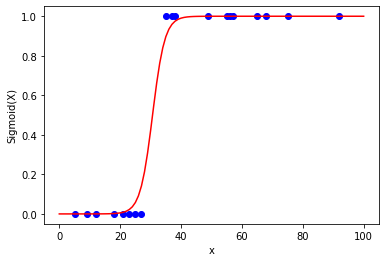

In [34]:
#trained model visualization
x_graph = np.linspace(0, 100, 101)
x_graph=np.reshape(x_graph, (101,1)) #predictors
ones = np.ones ((101,1)) #for the bias x_0
X_graph = np.concatenate((ones,x_graph),axis=1) #matrix of training data

z_graph = sigmoid(np.dot(X_graph,theta))

plt.plot(x_graph, z_graph, c="red")
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
x = test["Age"].to_numpy()
y = test["Children"].to_numpy()
plt.scatter(x, y, c="blue")

In [36]:
#PREDICTION

threshold = 0.5 #limit where sth is clasify as 1 and not anymore as 0

y_predict = sigmoid(np.dot(X,theta))

y_p = np.zeros(m)

for i in range(1,m):
    if y_predict[i]>threshold:
        y_p[i]=1
        
print(y)
print(y_p)
        
#y labelling
#y_predict return from the sigmoid
#y_p prediction based on a fixed threshold


[0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0]
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]


In [37]:
#EVALUATING THE MODEL

#F-MEASURE
print("F-measure:" , metrics.f1_score(y,y_p))
#the closer to 1, the better the performance is

#K-STATISTIC
print("Kappa:",metrics.cohen_kappa_score(y, y_p))
#the closer to 1, the better the performance is

#AREA UNDER CURVE (AUC), FROM RECEIVING OPERATION CHARACTERISTIC (ROC)
print("AUC:",metrics.roc_auc_score(y,y_p))
# if AUC>0.5 it means the classificator is better than a random process. Perfect classificator <=> AUC=1

#other metrics
print(metrics.classification_report(y,y_p))

F-measure: 1.0
Kappa: 1.0
AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        11

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



## ACTUAL DATA IMPORT AND PREPROCESS

In [38]:
# Read data from LOSS.mat
mat_loss = loadmat(data_folder + r'\LOSS.mat')
loss_matrix = mat_loss['LOSS']
loss_matrix = np.matrix(loss_matrix)
#select only the first  rows
loss_matrix = loss_matrix[0:900,:] #trying to take balance data somehow
# Convert into a Pandas Data Frame
loss = pd.DataFrame(loss_matrix, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR'])

# Read data from PAY.mat
mat_pay = loadmat(data_folder + r'\PAY.mat')
pay_matrix = mat_pay['PAY']
pay_matrix = np.matrix(pay_matrix)
#select only the first rows
pay_matrix = pay_matrix[0:900,:] #trying to take balance data somehow
# Convert into a Pandas Data Frame
pay = pd.DataFrame(pay_matrix, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR'])


# Adding a column to the DataFrames; the value of the column represents whether the mortgage has been paid back or defaulted
loss['is_paid'] = 0
pay['is_paid'] = 1

# Concatenate pay and loss data into one DataFrame
data_frames = [pay, loss]
pay_loss = pd.concat(data_frames)


#What follows is the first way i founded to standarize the data
#it is MANDATORY to do it all together with loss and pay
#doing so, the is_paid column standarizes to -1,1, the code below just turn -1 to 0
#i'd rather use 0 instead of -1 since the code is already desing for that label
#probably there is more efficient way to code it

scaler = StandardScaler()
pay_loss_standarized = scaler.fit_transform(pay_loss) 

print(pay_loss_standarized.shape)

pay_loss_STAND = pd.DataFrame(pay_loss_standarized, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR','is_paid'])

PAY_CORRECT=pay_loss_STAND['is_paid']==1
LOSS_CORRECT=pay_loss_STAND['is_paid']==-1

filtered_PAY = pay_loss_STAND[PAY_CORRECT]
filtered_LOSS = pay_loss_STAND[LOSS_CORRECT]

filtered_LOSS['is_paid']=0

data_frames = [filtered_PAY, filtered_LOSS]
pay_loss = pd.concat(data_frames)
        
# Adding a column to the DataFrames for the independent bias x_o in the literature
pay_loss['BIAS']=1


(1800, 18)


C:\Users\ainol\AppData\Local\Temp/ipykernel_2344/2623183014.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_LOSS['is_paid']=0


In [39]:
# Split data into training and validation sets
# Training data 70 %, validation data 30 %
train_data, validation_data = model_selection.train_test_split(pay_loss, test_size=0.3) #automatically shuffle

#NOTE: the shuffle is not considering the imbalanced data, maybe:
    #1. reuse the 0 to balance the data
    #2. divide the data taking into account the imbalance. e.g. 30% total = 30%pay + 30%loss. 
    #this idea would be also interesting to implement in the k-fold

#intially implemented without taking care of this -> LET'S SEE WHAT HAPPENS
    
#within the training data, k-fold cross validation will be implemented to select the best parameters
#validation set is only used to assess the model, no to select parameters

In [40]:
#Input vector and labelling

train_x = train_data[['BIAS','NOI', 'DSCR', 'LTV', 'Balance', 
                    'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                    'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                    'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR']].to_numpy() #already proper shape
train_y = train_data['is_paid'].to_numpy()
train_y = train_y.reshape(-1, 1)    

valid_x = validation_data[['BIAS','NOI', 'DSCR', 'LTV', 'Balance', 
                    'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                    'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                    'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR']].to_numpy() #already proper shape
valid_y = validation_data['is_paid'].to_numpy()
valid_y = valid_y.reshape(-1, 1)    


## BIVARIATE RELATIONSHIPS BETWEEN VARIABLES
At the moment, these are just the correlations I have found. This section needs explanations and a neat way of presenting the data. I should also add axis names or legends to the plots. Also: what units are each axis representing? Am I using the correct DataFrame; the values seem partially weird? - check from the original data

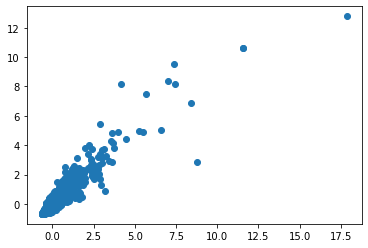

In [200]:
#plt.scatter(pay_loss.Year_Built, pay_loss.IR)
#plt.scatter(pay_loss.ZipPop, pay_loss.CS)
plt.scatter(pay_loss.PV_Ratio, pay_loss.NOI_Ratio)

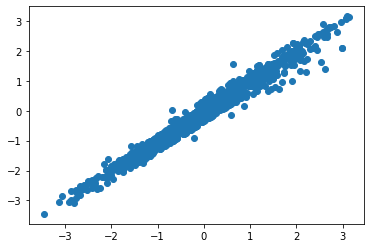

In [181]:
plt.scatter(pay_loss.ZipPop, pay_loss.CR)

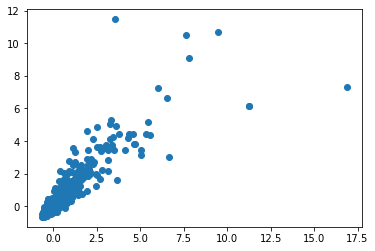

In [80]:
plt.scatter(pay_loss.NOI, pay_loss.Balance)
# plt.scatter(pay_loss.NOI, pay_loss.NOI_Ratio) <--- obviously correlated
# plt.scatter(pay_loss.Balance, pay_loss.NOI_Ratio) <--- also obviously correlated

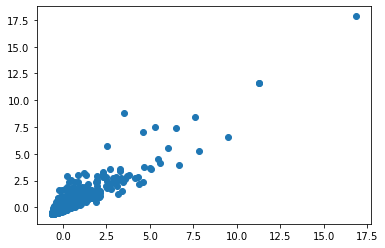

In [123]:
plt.scatter(pay_loss.NOI, pay_loss.PV_Ratio)
# --> plt.scatter(pay_loss.Balance, pay_loss.PV_Ratio)  
# and plt.scatter(pay_loss.PV_Ratio, pay_loss.NOI_Ratio) also correlated

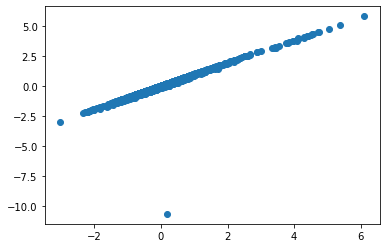

In [128]:
# Another obvious one that probably shouldn't be included in the final project
plt.scatter(pay_loss.Rate, pay_loss.Net_Mortgage_Rate)

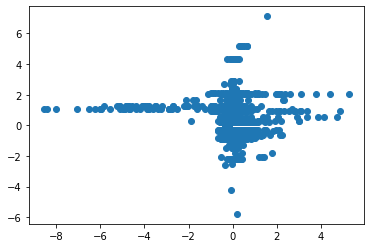

In [194]:
# For whatever reason, these do not appear linearly correlated (!!?)
plt.scatter(pay_loss.CS, pay_loss.CS_Ratio)

## IMPLEMENTATION OF THE LOGISTIC REGRESSION WITH THE ACTUAL DATA.
All predictors initially (k=17)

In [41]:
#TRAINING WITH K-FOLD CROSS VALIDATION FOR PARAMETER SELECTION

kf = KFold(n_splits=5)

#print(kf)

#print(kf.split(X))

k=17; # DO IT AUTOMATICALLY, related with the number of predictors=number of columns apart from labelling or bias term
threshold = 0.5

for train_index, test_index in kf.split(train_x):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_folded, X_test = train_x[train_index], train_x[test_index]
    y_train_folded, y_test = train_y[train_index], train_y[test_index]
    #model training and evaluation for every fold
    theta = np.random.rand(k+1,1)
    theta=logistic_train(theta,X_train_folded,y_train_folded)    
    y_p = sigmoid(np.dot(X_test,theta))
    #print(y_p.shape) to discover the 252
    y_predict = np.zeros(252) #252 comes from size of test data, to be automated
    for i in range(1,252): #this is just to control the threshold, no extrictly needed
        if y_p[i]>threshold:
            y_predict[i]=1
    print("AUC:",metrics.roc_auc_score(y_test,y_predict))
    

AUC: 0.7573084677419355
AUC: 0.7700888636793345
AUC: 0.7696572580645161
AUC: 0.7712250712250712
AUC: 0.755185934733114


# CONCLUSION: 
my classificator is pretty shitty, but at least it classify things

AUC need to be at leat around 0.7 for logistic regresion, the professor got that in his paper.

now, we are around 0.5, or even worse, meaning that that a random even a random clasifier will perform better. :(

## SELECTION OF THE MOST RELEVANT VARIABLES

This information may be relevant
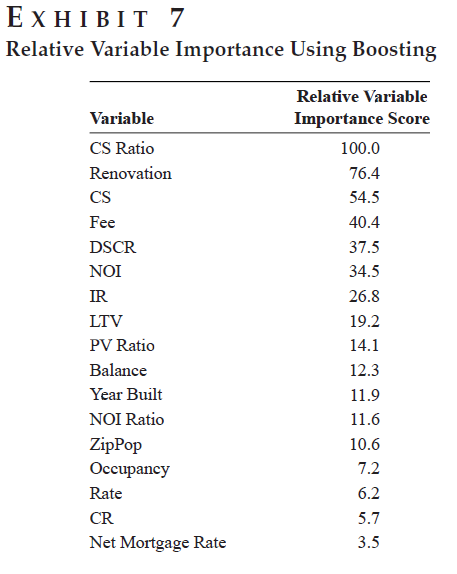 

## Forward and Backward Stepwise Regression

These need some adjusting, and I haven't quite figured out yet why my custom-made function selects different columns in
backward selection than SequentialFeatureSelection. (Related to the use of random forest classifier with SequentialFeatureSelection?)

In [42]:
# Build a Random Forest classifier for the feature selection
# (Use a different model in the final version?)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)

backward_feature_selection = sfs(rfc,
                                forward=False,
                                floating=False,
                                verbose=2,
                                scoring='r2',
                                k_features=5,
                                cv=5)

backward_feature_selection = backward_feature_selection.fit(train_x, train_data['is_paid'].to_numpy()) # train_y as a 1d vector

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   17.3s finished

[2022-02-18 09:42:08] Features: 17/5 -- score: 0.384112385951756[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   14.8s finished

[2022-02-18 09:42:23] Features: 16/5 -- score: 0.3682391701037371[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   13.2s finished

[2022-02-18 09:42:37] Features: 15/5 -- score: 0.37141257342832157[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [43]:
# Print out the selected features
feat_columns = list(backward_feature_selection.k_feature_idx_)
print("SELECTED COLUMNS:", feat_columns)

SELECTED COLUMNS: [3, 5, 6, 8, 14]


In [49]:
# Build a Linear Regression classifier for the feature selection
# (Use a different model in the final version?)
lr = LinearRegression()

backward_feature_selection = sfs(lr,
                                forward=False,
                                floating=False,
                                verbose=2,
                                scoring='r2',
                                k_features=5,
                                cv=5)

backward_feature_selection = backward_feature_selection.fit(train_x, train_data['is_paid'].to_numpy()) # train_y as a 1d vector

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished

[2022-02-18 09:47:51] Features: 17/5 -- score: 0.3202959154133282[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2022-02-18 09:47:51] Features: 16/5 -- score: 0.32439180922752636[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2022-02-18 09:47:51] Features: 15/5 -- score: 0.3260716119526848[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

In [50]:
# Print out the selected features
feat_columns = list(backward_feature_selection.k_feature_idx_)
print("SELECTED COLUMNS:", feat_columns)

SELECTED COLUMNS: [1, 3, 5, 14, 16]


In [57]:
# ACHTUNG! Need to remove bias etc. from the data used for this!

# THE WHOLE BLOCK: TO BE DELETED LATER. Keeping for reference/ comparison for now

#def get_stats(columns, train_y):
#    stats = sm.OLS(train_y, columns).fit()
#   print(stats.summary())
#    return stats
#get_stats(train_x, train_y)

predictors = train_data
pvalue_treshold = 0.05

# Backward Stepwise Regression
# Remove predictors until a certain treshold
stats = sm.OLS(train_y, predictors).fit()
print(stats.summary())
while True:
    largest_p = -1
    to_remove = -1
    # !!!! Here: Add something to assess how good each model is
    #print(len(predictors.columns), metrics.accuracy_score())
    for attrib_idx in range (0, len(predictors.columns)):
        if (stats.pvalues[attrib_idx] > largest_p):
            largest_p = stats.pvalues[attrib_idx]
            to_remove = attrib_idx
    if (to_remove == -1):
        print('Error with p values\n')
    if to_remove < pvalue_treshold:  # Treshold?? Note: let's discuss this together
        break
    print(list(predictors.columns))
    predictors = predictors.drop(predictors.columns[to_remove], axis=1) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.661e+31
Date:                Fri, 18 Feb 2022   Prob (F-statistic):               0.00
Time:                        09:54:00   Log-Likelihood:                 41968.
No. Observations:                1260   AIC:                        -8.390e+04
Df Residuals:                    1242   BIC:                        -8.381e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
NOI               -6.939e-18   9.89e-1

In [56]:
# Build a Random Forest classifier for the feature selection
# (Use a different model in the final version?)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)

forward_feature_selection = sfs(rfc,
                                k_features=5,
                                forward=True,
                                floating=False,
                                verbose=2,
                                scoring='accuracy',
                                cv=5)

forward_feature_selection = forward_feature_selection.fit(train_x, train_data['is_paid'].to_numpy()) # train_y as a 1d vector

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   21.2s finished

[2022-02-18 09:51:57] Features: 1/5 -- score: 0.8309523809523809[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   15.7s finished

[2022-02-18 09:52:13] Features: 2/5 -- score: 0.8452380952380952[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   15.9s finished

[2022-02-18 09:52:29] Features: 3/5 -- score: 0.8476190476190476[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [58]:
# Print out the selected features
feat_columns = list(forward_feature_selection.k_feature_idx_)
print("SELECTED COLUMNS:", feat_columns)

SELECTED COLUMNS: [0, 3, 6, 10, 14]
